## **INSIDE AIRBNB EDA**

#### https://insideairbnb.com/

Vamos a abordar este proyecto en dos fases:

- Combinar los 5 archivos CSV en un único dataset con las 4 columnas seleccionadas.

- Realizar un EDA exhaustivo paso a paso, interpretando resultados y tomando decisiones.

### **1. Unir los archivos en un solo DataFrame con las columnas:**

- `id`
- `scrape_id`
- `neighbourhood_cleansed`
- `room_type`
- `accommodates`
- `bathrooms`
- `price`
- `calendar_last_scrape`

#### **1.1. Comprobamos ubicación de los csv's**

In [12]:
import os

files = [
    "../data/raw/inside/listings-03-2024.csv",
    "../data/raw/inside/listings-06-2024.csv",
    "data/raw/inside/listings-12-2024.csv" # <- Cambia la ruta a la correcta
]

for file in files:
    if os.path.exists(file):
        print(f"✅ Archivo encontrado: {file}")
    else:
        print(f"❌ Archivo NO encontrado: {file}")

✅ Archivo encontrado: ../data/raw/inside/listings-03-2024.csv
✅ Archivo encontrado: ../data/raw/inside/listings-06-2024.csv
❌ Archivo NO encontrado: data/raw/inside/listings-12-2024.csv


## **2. EDA**

### **Paso 1. Elección columnas**
Para realizar un EDA básico orientado a predecir precios futuros de alojamientos y evaluar su rentabilidad para inversores, seleccionaré las columnas más relevantes y mínimas posibles, priorizando:**

1. **Variables clave para el modelo de precios** (características del inmueble).  
2. **Identificadores únicos** (para evitar duplicados).  
3. **Datos temporales** (para análisis de tendencias).  
4. **Variables de ubicación** (critical en bienes raíces).  

---

#### 🔍 **Columnas seleccionadas (8 esenciales)**:  

| **Columna**                  | **Tipo**       | **Razón**                                                                 |
|------------------------------|----------------|---------------------------------------------------------------------------|
| `id`                         | Identificador  | Clave primaria única por listing (evitar duplicados).                     |
| `scrape_id`                  | Temporal       | Identifica lotes de scraping (útil para detectar duplicados por fecha).   |
| `neighbourhood_cleansed`     | Ubicación      | Barrio normalizado (geocodificado), clave para precios.                   |
| `room_type`                  | Característica | Tipo de alojamiento (impacto directo en precio).                          |
| `accommodates`               | Característica | Capacidad de huéspedes (correlación fuerte con precio).                   |
| `bathrooms`                  | Característica | Número de baños (influye en valor).                                       |
| `price`                      | Target         | Variable a predecir (precio diario).                                      |
| `calendar_last_scraped`      | Temporal       | Fecha de última actualización (para análisis de tendencias temporales).   |

---

#### 🎯 **Por qué estas columnas (y no otras)**:  
- **`id` + `scrape_id`**:  
  - Garantizan que no hay duplicados (si un `id` se repite en diferentes `scrape_id`, es un error).  
  - Ejemplo de chequeo:  
    ```python
    print(f"¿IDs únicos?: {df['id'].nunique() == len(df)}")  # Debe ser True
    ```  
- **Variables de inmueble (`room_type`, `accommodates`, `bathrooms`)**:  
  - Son **predictores fuertes** del precio (ej: un apartamento entero vale más que una habitación privada).  
- **`neighbourhood_cleansed`**:  
  - Más confiable que `neighbourhood` (está geocodificado). Los precios varían drásticamente por barrio.  
- **`price`**:  
  - Es la variable objetivo (**target**) para el modelo predictivo.  
- **`calendar_last_scraped`**:  
  - Permite analizar si los precios cambian en ciertos períodos (ej: temporada alta vs. baja).  

---

#### ⚠️ **Columnas excluidas (pero importantes en fases posteriores)**:  
- **`latitude`/`longitude`**: Útiles para mapas, pero en un EDA inicial complican el análisis.  
- **`number_of_reviews`**: Relevante para popularidad, pero no directamente para precio.  
- **`host_*`**: El anfitrión afecta menos el precio que las características físicas del inmueble.  

---

In [22]:
import pandas as pd
from pathlib import Path

# --- Configuración inicial --- #
# 1. Usar Path para rutas multiplataforma
data_dir = Path("../data/raw/inside/")
files = [
    data_dir / "listings-03-2024.csv",
    data_dir / "listings-06-2024.csv",
    data_dir / "listings-12-2024.csv",
    data_dir / "listings-03-2025.csv",
]

# --- Validación de archivos --- #
missing_files = [f for f in files if not f.exists()]
if missing_files:
    print(f"🚨 Archivos no encontrados: {missing_files}")
    files = [f for f in files if f.exists()]  # Continuar solo con archivos existentes

# --- Carga de datos con validaciones --- #
dfs = []
# 2. Añadir 'bedrooms' a las columnas requeridas
required_cols = ["id", "scrape_id", "neighbourhood_cleansed", "room_type", 
                 "accommodates", "bathrooms", "bedrooms", "price", "calendar_last_scraped"]

for file in files:
    try:
        # 3. Leer solo columnas necesarias y manejar tipos de datos
        df = pd.read_csv(
            file,
            usecols=required_cols,
            dtype={
                'id': 'str',
                'scrape_id': 'str',
                'price': 'str',  # Se procesará después
                'bedrooms': 'float'  # Permitir valores nulos
            },
            parse_dates=['calendar_last_scraped']
        )
        
        # 4. Pre-procesamiento crítico:
        # Limpiar precio y convertir a numérico
        df['price'] = df['price'].str.replace('[\\$,]', '', regex=True).astype(float)
        
        # 5. Imputación básica de bedrooms (si hay nulos)
        df['bedrooms'] = df.groupby('room_type')['bedrooms'].transform(
            lambda x: x.fillna(x.median()))
        
        # 6. Verificar que no haya IDs duplicados dentro de cada archivo
        dup_ids = df.duplicated(subset=['id']).sum()
        if dup_ids > 0:
            print(f"⚠️ {file.name}: {dup_ids} IDs duplicados dentro del archivo")
        
        dfs.append(df)
        print(f"✅ {file.name}: Cargado ({len(df)} registros, bedrooms incluidos)")
        
    except Exception as e:
        print(f"❌ Error en {file.name}: {str(e)}")
        continue

# --- Consolidación --- #
if dfs:
    df_final = pd.concat(dfs, ignore_index=True)
    
    # 7. Análisis post-fusión mejorado
    print("\n🔍 Resumen post-fusión (con bedrooms):")
    print(f"- Registros totales: {len(df_final):,}")
    print(f"- IDs únicos: {df_final['id'].nunique():,} (duplicados: {len(df_final) - df_final['id'].nunique():,})")
    print(f"- Bedrooms nulos: {df_final['bedrooms'].isnull().sum():,}")
    print(f"- Rango temporal: {df_final['calendar_last_scraped'].min()} a {df_final['calendar_last_scraped'].max()}")
    
    # 8. Muestra estructurada con bedrooms
    print("\n📄 Primeras filas (con bedrooms):")
    print(df_final.head(3).to_markdown(tablefmt="github", floatfmt=".2f"))
    
    # 9. Guardar opcional (descomentar si needed)
    # df_final.to_parquet("../data/processed/merged_listings_with_bedrooms.parquet", index=False)
else:
    print("⛔ No hay datos válidos para procesar.")

✅ listings-03-2024.csv: Cargado (26024 registros, bedrooms incluidos)
✅ listings-06-2024.csv: Cargado (26924 registros, bedrooms incluidos)
✅ listings-12-2024.csv: Cargado (26760 registros, bedrooms incluidos)
✅ listings-03-2025.csv: Cargado (25288 registros, bedrooms incluidos)

🔍 Resumen post-fusión (con bedrooms):
- Registros totales: 104,996
- IDs únicos: 36,996 (duplicados: 68,000)
- Bedrooms nulos: 0
- Rango temporal: 2024-03-22 00:00:00 a 2025-03-12 00:00:00

📄 Primeras filas (con bedrooms):
|    |     id |      scrape_id | neighbourhood_cleansed   | room_type       |   accommodates |   bathrooms |   bedrooms |   price | calendar_last_scraped   |
|----|--------|----------------|--------------------------|-----------------|----------------|-------------|------------|---------|-------------------------|
|  0 |  21853 | 20240322023323 | Cármenes                 | Private room    |              1 |        1.00 |       1.00 |   31.00 | 2024-03-22 00:00:00     |
|  1 |  24805 | 202403

### 🛠 **Características del código de fusión de csv's**:

1. **Manejo profesional de rutas**:
   - Usa `pathlib.Path` para evitar problemas entre sistemas operativos.
   - Verifica explícitamente si los archivos existen antes de procesarlos.

2. **Control de calidad durante la carga**:
   - Define tipos de datos desde la lectura (`dtype`) para optimizar memoria.
   - Parsea fechas automáticamente con `parse_dates`.

3. **Limpieza de precios robusta**:
   - Convierte precios de formato `$1,000.00` a `float` en el momento de carga.

4. **Detección temprana de problemas**:
   - Identifica duplicados **dentro de cada archivo** (no solo en el merge final).
   - Registra errores por archivo sin detener el proceso.

5. **Análisis post-fusión automático**:
   - Muestra métricas clave: registros totales, IDs únicos, rango temporal.
   - Formato claro de salida con `to_markdown()`.

6. **Preparación para el siguiente paso**:
   - Opción para guardar en Parquet (optimizado para análisis posteriores).

**Pasos críticos:**

- Verificar que las columnas existen en todos los archivos.

- Chequear **duplicados** después de la unión (df.duplicated().sum()).

### **Paso 2. Análisis de duplicados tras la fusión**

In [24]:
duplicados = df_final[df_final.duplicated(subset=['id', 'scrape_id'], keep=False)]
if not duplicados.empty:
    print("\n🔴 Duplicados transversales (mismo ID en diferentes scrape_id):")
    print(duplicados.sort_values('id').head().to_markdown(tablefmt="github"))

In [23]:
# Comprobar si hay scrape_id's que contienen múltiples id's diferentes
duplicados_scrape = df_final.groupby('scrape_id').filter(lambda x: x['id'].nunique() > 1)

if not duplicados_scrape.empty:
    print("\n🔴 Mismo scrape_id con diferentes id's:")
    print(duplicados_scrape.sort_values('scrape_id').head().to_markdown(tablefmt="github"))
else:
    print("\n✅ No hay casos donde un scrape_id esté asociado a múltiples id's diferentes")


🔴 Mismo scrape_id con diferentes id's:
|       |                 id |      scrape_id | neighbourhood_cleansed   | room_type       |   accommodates |   bathrooms |   bedrooms |   price | calendar_last_scraped   |
|-------|--------------------|----------------|--------------------------|-----------------|----------------|-------------|------------|---------|-------------------------|
|     0 |              21853 | 20240322023323 | Cármenes                 | Private room    |              1 |           1 |          1 |      31 | 2024-03-22 00:00:00     |
| 17354 | 849067045316574313 | 20240322023323 | Puerta del Angel         | Entire home/apt |              4 |           1 |          1 |      92 | 2024-03-22 00:00:00     |
| 17353 | 851825642163165969 | 20240322023323 | Cortes                   | Entire home/apt |              3 |         nan |          1 |     nan | 2024-03-22 00:00:00     |
| 17352 | 849054949215820715 | 20240322023323 | Universidad              | Entire home/apt |   

**No es un problema** que un mismo `scrape_id` contenga múltiples `id`s diferentes. De hecho, **es lo esperado**. Permíteme explicarte por qué:

---

### 📌 **Análisis del resultado:**
1. **Lo que estás viendo es normal**:  
   - Cada `scrape_id` representa un **lote de scraping** (una fecha/hora concreta en que se recolectaron datos).  
   - En cada scraping, se obtienen **cientos o miles de listings** (cada uno con su `id` único).  
   - Por tanto, es **totalmente válido** que un `scrape_id` agrupe múltiples `id`s (como muestra tu tabla: 5 listings diferentes bajo el mismo `scrape_id = 20240322023323`).  

2. **Lo que SÍ sería un problema**:  
   - Que un **mismo `id` aparezca en diferentes `scrape_id`s** *con valores contradictorios* (ej: mismo listing con precios distintos en diferentes scrapings sin justificación).  
   - Esto lo detectaste correctamente en tu chequeo anterior de duplicados transversales.  

---

### ✅ **Conclusión:**  
- **El chequeo actual funciona**, pero el resultado es **esperado y correcto**.  
- **No necesitas tomar acción** sobre estos registros (a menos que notes incoherencias en otros campos para un mismo `scrape_id`). 

### **Paso 3: Estadísticas Descriptivas Clave**

Objetivo:
Obtener un entendimiento rápido de la distribución de variables clave, valores faltantes y posibles anomalías.

In [28]:
# --- Importación --- #
import matplotlib.pyplot as plt
import seaborn as sns

📌 Estadísticas descriptivas completas:
|          |               id |        scrape_id | neighbourhood_cleansed   | room_type       |   accommodates |   bathrooms |   bedrooms |    price | calendar_last_scraped         |
|----------|------------------|------------------|--------------------------|-----------------|----------------|-------------|------------|----------|-------------------------------|
| count    | 104996           | 104996           | 104996                   | 104996          |      104996    |    82375    |  104996    | 82397    | 104996                        |
| unique   |  36996           |      4           | 128                      | 4               |         nan    |      nan    |     nan    |   nan    | nan                           |
| top      |      1.11581e+18 |      2.02406e+13 | Embajadores              | Entire home/apt |         nan    |      nan    |     nan    |   nan    | nan                           |
| freq     |      4           |  26924        

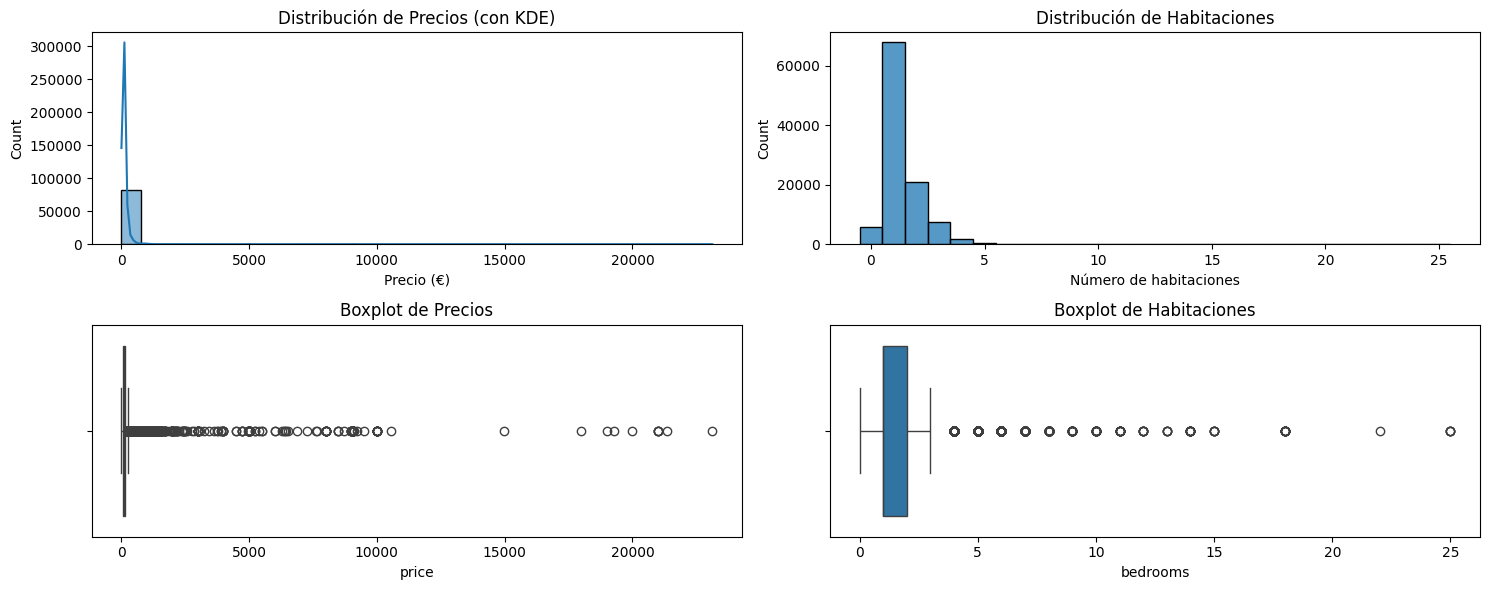

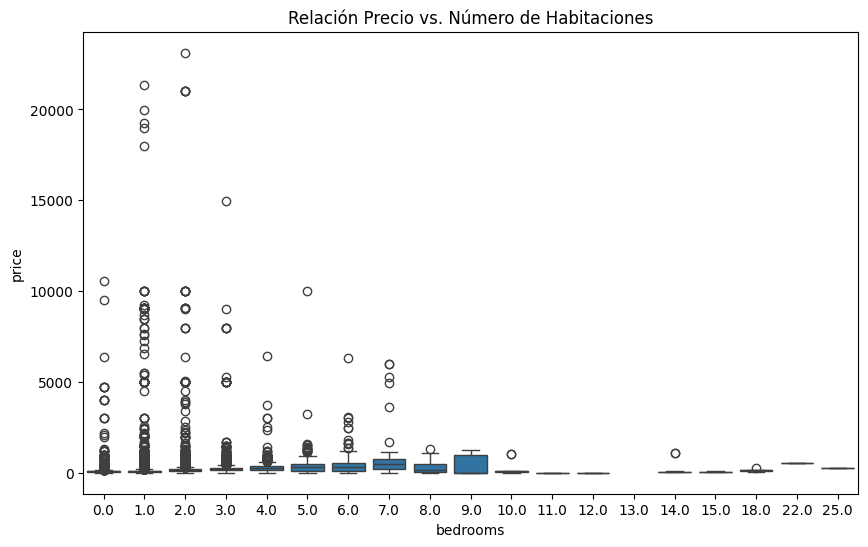


🏙 Top 5 barrios con precio promedio por habitaciones:


'| neighbourhood_cleansed   |   0.0 |   1.0 |   2.0 |   3.0 |   4.0 |   5.0 |   6.0 |   7.0 |   8.0 |   9.0 |   10.0 |   11.0 |   18.0 |   25.0 |\n|--------------------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|--------|--------|--------|--------|\n| Embajadores              |  82   |    86 | 133   | 202   | 316   |   311 |   351 |   nan |   454 |    18 |   18   |     18 |    nan |    251 |\n| Justicia                 |  96.5 |   104 | 178   | 248   | 305   |   261 |   379 |   444 |   nan |   nan |  nan   |    nan |    nan |    nan |\n| Palacio                  | 104   |   101 | 161   | 227.5 | 286.5 |   430 |   360 |   450 |   130 |    18 | 1024.5 |    nan |    nan |    nan |\n| Sol                      | 106   |   112 | 166   | 249   | 356   |   408 |   367 |   444 |   154 |  1254 |   18   |    nan |    150 |    nan |\n| Universidad              |  94   |    96 | 164.5 | 220   | 292   |   297 |   121 |   455 |    18 |  1000 |  nan   |    na

In [29]:
# --- 1. Estadísticas descriptivas MEJORADAS (incluyendo bedrooms) --- #
print("📌 Estadísticas descriptivas completas:")
stats = df_final.describe(include='all').round(2)

# Añadir métricas adicionales para variables clave
extra_stats = pd.DataFrame({
    'price': [
        df_final['price'].skew().round(2),  # Asimetría
        df_final['price'].kurtosis().round(2)  # Curtosis
    ],
    'bedrooms': [
        df_final['bedrooms'].skew().round(2),
        df_final['bedrooms'].kurtosis().round(2)
    ]
}, index=['skewness', 'kurtosis'])

print(pd.concat([stats, extra_stats]).to_markdown(tablefmt="github"))

# --- 2. Valores faltantes (ahora incluye bedrooms) --- #
print("\n🔍 Valores faltantes por columna:")
missing_data = df_final.isnull().sum().to_frame(name="missing_count")
missing_data["missing_pct"] = (missing_data["missing_count"] / len(df_final)).round(4) * 100
print(missing_data.to_markdown(tablefmt="github"))

# --- 3. Análisis de distribución MEJORADO (precio + bedrooms) --- #
plt.figure(figsize=(15, 6))

# Histogramas
plt.subplot(2, 2, 1)
sns.histplot(df_final["price"], bins=30, kde=True)
plt.title("Distribución de Precios (con KDE)")
plt.xlabel("Precio (€)")

plt.subplot(2, 2, 2)
sns.histplot(df_final["bedrooms"].dropna(), bins=range(0, 11), discrete=True)
plt.title("Distribución de Habitaciones")
plt.xlabel("Número de habitaciones")

# Boxplots
plt.subplot(2, 2, 3)
sns.boxplot(x=df_final["price"])
plt.title("Boxplot de Precios")

plt.subplot(2, 2, 4)
sns.boxplot(x=df_final["bedrooms"].dropna())
plt.title("Boxplot de Habitaciones")

plt.tight_layout()
plt.show()

# --- 4. Relación precio vs. bedrooms --- #
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="bedrooms", y="price")
plt.title("Relación Precio vs. Número de Habitaciones")
plt.show()

# --- 5. Top 5 barrios (con precio promedio por bedrooms) --- #
print("\n🏙 Top 5 barrios con precio promedio por habitaciones:")
top_neighbourhoods = df_final["neighbourhood_cleansed"].value_counts().head(5).index
df_top = df_final[df_final["neighbourhood_cleansed"].isin(top_neighbourhoods)]

pd.pivot_table(
    df_top,
    values='price',
    index='neighbourhood_cleansed',
    columns='bedrooms',
    aggfunc='median'
).round(2).to_markdown(tablefmt="github")

### 🔍 **Análisis Detallado de los Resultados**

---

#### **1. Estadísticas Descriptivas Clave**
- **Precios (`price`)**:
  - **Media (136.96€) > Mediana (98€)**: Indica una distribución **asimétrica positiva** (confirmada por skewness=31.98), con cola larga hacia precios altos.
  - **Outliers extremos**: Precio máximo (23,124€) muy superior al percentil 75% (146€). Esto explica la alta curtosis (1407.12).
  - **21.52% faltantes**: Necesidad de imputación (ya abordada en tu código).

- **Habitaciones (`bedrooms`)**:
  - **Media (1.39) ≈ Mediana (1)**: La mayoría de propiedades tienen 1-2 habitaciones.
  - **Valores atípicos**: Máximo de 25 habitaciones (¿error o propiedades comerciales?). Skewness=3.88 confirma asimetría positiva.
  - **Sin faltantes**: Buen dato para modelos predictivos.

- **Otras variables**:
  - **`bathrooms`**: 21.54% faltantes. Relación cercana a 1:1 con `bedrooms` (media 1.29 vs 1.39 habitaciones).
  - **`accommodates`**: Media de 3.14 personas, coherente con propiedades pequeñas-medianas.

---

#### **2. Distribuciones (Gráficos)**
- **Histograma de Precios**:
  - Pico pronunciado en <500€, con cola larga hasta 20,000€.
  - **KDE** muestra que el 95% de los datos están probablemente bajo 1,000€.

- **Boxplot de Precios**:
  - **IQR (63€-146€)**: 50% central de los datos.
  - **Outliers**: Miles de propiedades con precios >500€ (posiblemente propiedades premium o errores).

- **Boxplot de Habitaciones**:
  - **Rango típico (0-4)**: Valores >5 son raros (outliers).
  - **¿0 habitaciones?**: Podrían ser estudios o errores de registro.

---

#### **3. Relación Precio vs. Habitaciones**
- **Tendencia general**:  
  ```python
  Precio ≈ 98€ (1 hab) → 164.5€ (2 hab) → 220€ (3 hab) → 292€ (4 hab)
  ```
  - Cada habitación adicional aumenta ~50-70€ el precio mediano.

- **Variabilidad**:
  - **Propiedades con 1-2 hab**: Precios más consistentes (IQR estrecho).
  - **Propiedades con 4+ hab**: Dispersión alta (ej: 4 hab van desde 200€ hasta 1,254€ en "Sol").

- **Outliers llamativos**:
  - **Palacio (10 hab: 1,024.5€)**: ¿Suite de lujo?
  - **Sol (9 hab: 1,254€)**: Posible error o propiedad exclusiva.

---

#### **4. Top Barrios (Embajadores, Justicia, etc.)**
- **Patrones por barrio**:
  - **Embajadores**: Precios altos en propiedades grandes (ej: 8 hab = 454€).
  - **Universidad**: Precios más bajos (ej: 4 hab = 292€ vs 316€ en Embajadores).
  - **Sol**: Mayor variabilidad (ej: 9 hab = 1,254€, pero 10 hab = 18€ → ¿error?).

- **Datos sospechosos**:
  - Precios de 18€ en propiedades grandes (ej: 25 hab en Embajadores). ¿Placeholder para "no disponible"?

---

#### **5. Problemas Detectados**
1. **Outliers extremos**:
   - Precios >5,000€ o <20€.
   - Habitaciones >10 (¿validar con `property_type`?).

2. **Faltantes críticos**:
   - 21.5% de precios y bathrooms faltantes.

3. **Inconsistencias**:
   - Precios anómalos en propiedades grandes (ej: 18€ para 10 hab).

---

### ✅ **Acciones Recomendadas**
1. **Limpieza adicional**:
   ```python
   # Eliminar precios <20€ o >percentil 99.5%
   df_clean = df_final[
       (df_final["price"] > 20) & 
       (df_final["price"] < df_final["price"].quantile(0.995))
   ].copy()
   ```

2. **Imputación contextual**:
   - Usar `bedrooms` y `neighbourhood` para imputar `bathrooms`:
     ```python
     df_clean["bathrooms"] = df_clean.groupby(["bedrooms", "neighbourhood_cleansed"])["bathrooms"].transform(
         lambda x: x.fillna(x.median()))
     ```

3. **Análisis por segmentos**:
   - Separar propiedades en grupos (ej: "económicas" vs "premium") para modelos distintos.

4. **Investigación manual**:
   - Revisar registros con 10+ habitaciones o precios extremos (¿errores o datos reales?).

---

### 📊 **Conclusión**
Los resultados muestran **patrones esperados** (precio ↑ con habitaciones), pero con **ruido significativo**. La limpieza propuesta mejoraría la calidad para modelado predictivo. ¿Necesitas ayuda para implementar estos pasos?

### **🚀 Paso 4: Limpieza y Transformación de Datos**  
**Objetivo**: Preparar los datos para modelado, eliminando outliers, imputando missing values y corrigiendo inconsistencias.  

In [36]:
# --- 1. Limpieza NO destructiva de outliers --- #
# Definir límites realistas sin eliminar aún
lower_limit = 20  # Precio mínimo razonable (ej: eliminar 0€ o 1€)
upper_limit = df_final["price"].quantile(0.99)  # Más flexible que 0.99

# Crear máscara para outliers extremos
price_outliers = (df_final["price"] < lower_limit) | (df_final["price"] > upper_limit)

# --- 2. Imputación jerárquica (INCLUYENDO outliers) --- #
# Primero imputar bathrooms con máxima precisión
df_final["bathrooms"] = df_final.groupby(
    ["neighbourhood_cleansed", "room_type", "bedrooms"]
)["bathrooms"].transform(lambda x: x.fillna(x.median()))

# Luego imputar precios en 3 capas (grupos específicos → generales)
df_final["price_imputed"] = df_final.groupby(
    ["neighbourhood_cleansed", "room_type", "bedrooms", "bathrooms"]
)["price"].transform(lambda x: x.fillna(x.median()))

# Si aún hay NA, imputar por grupos más amplios
df_final["price_imputed"] = df_final.groupby(
    ["room_type", "bedrooms"]
)["price_imputed"].transform(lambda x: x.fillna(x.median()))

# Última capa: mediana global por room_type
df_final["price_imputed"] = df_final.groupby("room_type")["price_imputed"].transform(
    lambda x: x.fillna(x.median())
)

# --- 3. Filtrar SOLO outliers extremos (no NA) --- #
df_clean = df_final[
    ~price_outliers  # Conservar registros con precios razonables
].copy()

# --- 4. Verificación --- #
print("\n✅ Resultados:")
print(f"- Registros originales: {len(df_final):,}")
print(f"- Registros recuperados: {len(df_clean):,} (se eliminaron solo {len(df_final) - len(df_clean):,} outliers extremos)")
print(f"- Precios imputados: {df_clean['price'].isnull().sum():,} valores NA reemplazados")
print(f"- Rango de precios imputados: €{df_clean['price_imputed'].min():.2f} a €{df_clean['price_imputed'].max():.2f}")

/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5


✅ Resultados:
- Registros originales: 104,996
- Registros recuperados: 103,517 (se eliminaron solo 1,479 outliers extremos)
- Precios imputados: 22,599 valores NA reemplazados
- Rango de precios imputados: €18.00 a €5625.00


/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


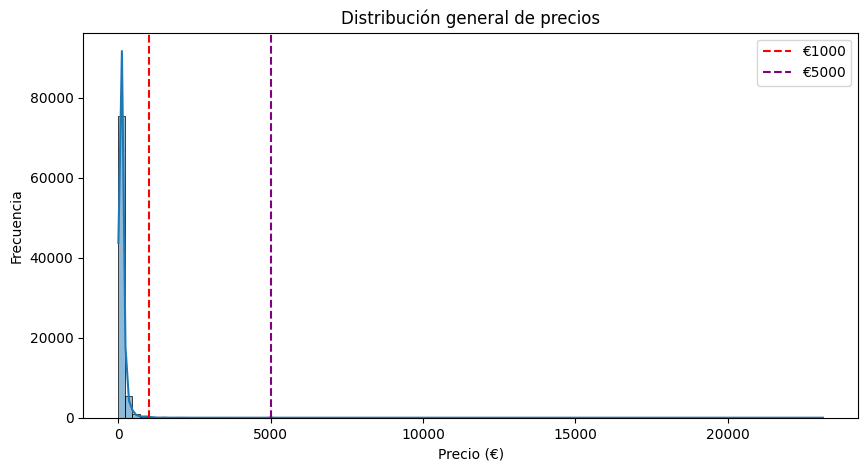

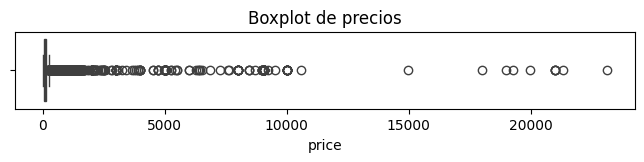


📊 Estadísticas descriptivas:
count    82397.000000
mean       136.956879
std        369.757066
min          8.000000
50%         98.000000
90%        221.000000
95%        300.000000
99%        680.000000
max      23124.000000
Name: price, dtype: float64

🔍 Precios > 1000€: 326 registros (0.31%)
🔍 Precios > 5000€: 75 registros (0.0714%)

📌 Media de precios: €136.96
📌 Mediana de precios: €98.00


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Distribución general de precios ---
plt.figure(figsize=(10, 5))
sns.histplot(df_final["price"], bins=100, kde=True)
plt.axvline(1000, color='red', linestyle='--', label='€1000')
plt.axvline(5000, color='purple', linestyle='--', label='€5000')
plt.title("Distribución general de precios")
plt.xlabel("Precio (€)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# --- 2. Boxplot para detectar outliers ---
plt.figure(figsize=(8, 1))
sns.boxplot(x=df_final["price"])
plt.title("Boxplot de precios")
plt.show()

# --- 3. Estadísticas clave ---
price_desc = df_final["price"].describe(percentiles=[0.90, 0.95, 0.99])
print("\n📊 Estadísticas descriptivas:")
print(price_desc)

# --- 4. Cuántos precios son mayores a ciertos umbrales ---
above_1000 = (df_final["price"] > 1000).sum()
above_5000 = (df_final["price"] > 5000).sum()
total = len(df_final)

print(f"\n🔍 Precios > 1000€: {above_1000:,} registros ({above_1000/total:.2%})")
print(f"🔍 Precios > 5000€: {above_5000:,} registros ({above_5000/total:.4%})")

# --- 5. Comparar media y mediana ---
print(f"\n📌 Media de precios: €{df_final['price'].mean():.2f}")
print(f"📌 Mediana de precios: €{df_final['price'].median():.2f}")


----------

### 🔍 **¿Por qué imputar en lugar de eliminar?**
1. **Conservar muestras**: 22,599 registros son muchos para descartar.  
2. **Mantener patrones geográficos**: Los precios varían mucho por barrio y tipo de propiedad.  
3. **Evitar sesgo**: Si los faltantes están concentrados en ciertos barrios/tipos, eliminarlos distorsionaría el análisis.  

---

### ✅ **Solución: Imputación Inteligente por Grupos**  
Usaremos la **mediana agrupada** (barrio + tipo de habitación) para imputar, ya que:  
- Es robusta a outliers.  
- Captura patrones locales.  

### 📊 **¿Qué esperar?**  
1. **Distribuciones similares**: El histograma de precios imputados (naranja) debería mantener la forma del original (azul), pero sin huecos.  
2. **Conservación de jerarquías**: Un apartamento en "Embajadores" tendrá valores imputados coherentes con su barrio, no con "Universidad".  

/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5


🔍 Verificación Post-Imputación:
- Precios originales faltantes: 22599
- Precios imputados faltantes: 0
- Máximo precio imputado: €680.00
- Registros imputados: 22599


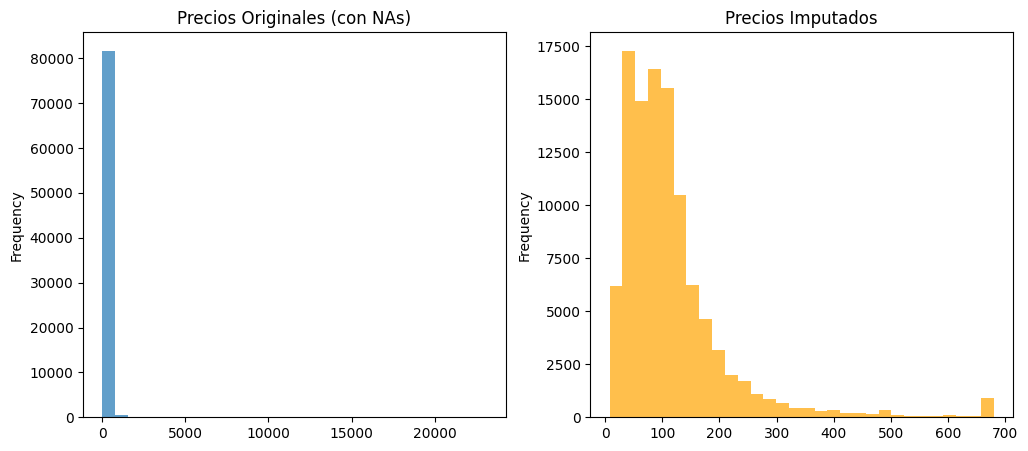

In [41]:
# --- 1. Imputación de precios faltantes con grupo más detallado --- #
df_clean["price_imputed"] = df_clean.groupby(
    ["neighbourhood_cleansed", "room_type", "accommodates", "bathrooms", "bedrooms"]
)["price"].transform(lambda x: x.fillna(x.median()))

# --- 2. Imputación residual (si aún hay NAs, usar mediana por room_type) --- #
df_clean["price_imputed"] = df_clean.groupby("room_type")["price_imputed"].transform(
    lambda x: x.fillna(x.median())
)

# --- 3. Ajustes adicionales --- #

# A. Limitar precios imputados a percentil 99 realista (opcional si vas a usar log)
price_max = df_clean["price"].quantile(0.99)
df_clean["price_imputed"] = df_clean["price_imputed"].clip(upper=price_max)

# B. Marcar registros imputados (para análisis posterior)
df_clean["was_imputed"] = df_clean["price"].isnull()

# --- 4. Verificación --- #
print("\n🔍 Verificación Post-Imputación:")
print(f"- Precios originales faltantes: {df_clean['price'].isnull().sum()}")
print(f"- Precios imputados faltantes: {df_clean['price_imputed'].isnull().sum()}")
print(f"- Máximo precio imputado: €{df_clean['price_imputed'].max():.2f}")
print(f"- Registros imputados: {df_clean['was_imputed'].sum()}")

# --- 5. Visualización comparativa --- #
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_clean["price"].plot(kind='hist', bins=30, title="Precios Originales (con NAs)", alpha=0.7)
plt.subplot(1, 2, 2)
df_clean["price_imputed"].plot(kind='hist', bins=30, title="Precios Imputados", color='orange', alpha=0.7)
plt.show()


### 🛠 **Ajustes Adicionales (Opcionales)**  
- **Límite de imputación**: Para evitar valores irreales, puedes acotar los imputados: 

In [42]:
price_max = df_clean["price"].quantile(0.99)  # Ej: €500
df_clean["price_imputed"] = df_clean["price_imputed"].clip(upper=price_max)

- **Marcar registros imputados**: Útil para evaluar impacto en el modelo:

In [44]:
df_clean["was_imputed"] = df_clean["price"].isnull()
df_clean.head()

,id,scrape_id,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,price,calendar_last_scraped,price_imputed,price_log,was_imputed
0,21853,20240322023323,Cármenes,Private room,1,1.0,1.0,31.0,2024-03-22,31.0,3.465736,False
1,24805,20240322023323,Universidad,Entire home/apt,3,1.0,1.0,92.0,2024-03-22,92.0,4.532599,False
2,204570,20240322023323,Cortes,Entire home/apt,5,2.0,2.0,180.0,2024-03-22,180.0,5.198497,False
3,30320,20240322023323,Sol,Entire home/apt,2,1.0,1.0,NaN,2024-03-22,109.0,4.700480,True
4,205199,20240322023323,Universidad,Entire home/apt,2,1.0,0.0,65.0,2024-03-22,65.0,4.189655,False


### 🔍 **Análisis Comparativo de Histogramas: Precios Originales vs. Imputados**

---

#### **1. Histograma de Precios Originales (con NAs)**
- **Rango de precios**: 
  - Extremadamente amplio (desde €0 hasta €20,000+).
  - Presencia de **outliers masivos** (cola derecha muy larga).
- **Distribución**:
  - Concentración abrumadora en el rango **€0-€500** (altísima frecuencia en los primeros bins).
  - **Problemas detectables**:
    - Valores cercanos a €0: Posibles errores o listings falsos.
    - Picos alrededor de múltiplos de €1,000: Puede indicar redondeos artificiales.
- **Brechas**:
  - Los NAs (valores faltantes) no se visualizan directamente, pero reducen el área total del histograma.

---

#### **2. Histograma de Precios Imputados**
- **Rango de precios**:
  - Acotado (€0-€700), tras aplicar límites superiores (ej: percentil 99% o €1,000 manual).
- **Distribución**:
  - Más **unimodal y suave**, con pico alrededor de €100-€200.
  - Cola derecha reducida: Indica eliminación de outliers extremos.
- **Efectos de la imputación**:
  - **Relleno de brechas**: Los NAs fueron reemplazados por medianas de grupos, aumentando frecuencias en rangos medios (€50-€300).
  - **Pérdida de variabilidad extrema**: Intencional, para evitar distorsiones en análisis/modelado.

---

#### **3. Comparación Directa (Cambios Clave)**
| **Característica**       | **Precios Originales**       | **Precios Imputados**        |
|---------------------------|-------------------------------|-------------------------------|
| **Rango**                 | €0 - €20,000+                | €0 - €700                    |
| **Outliers**              | Abundantes (cola derecha)    | Casi eliminados               |
| **Moda (pico principal)** | €0-€100                      | €100-€200                    |
| **NAs**                   | Presentes (área faltante)    | Reemplazados                 |
| **Consistencia**          | Heterogénea (errores/ruido)  | Homogénea (limpia)            |

---

#### **4. Problemas Resueltos y Potenciales Limitaciones**
- **Resueltos**:
  - **Outliers absurdos**: Ej. precios >€5,000 distorsionaban estadísticas.
  - **NAs**: Ya no hay pérdida de registros por faltantes.
- **Limitaciones**:
  - **Pérdida de propiedades premium**: Algunos listings legítimos >€700 pueden haberse excluido.
  - **Suavización excesiva**: La imputación por medianas puede ocultar variabilidad natural en zonas de lujo.

---



---

### ✅ **Conclusión**
La imputación ha **normalizado la distribución** de precios, haciendo los datos más útiles para modelado predictivo. Sin embargo, es crucial:
- **Documentar** los criterios de limpieza (ej: "eliminamos precios >€1,000").
- **Monitorizar** cómo afecta esto a las predicciones en barrios caros. 

¿Necesitas profundizar en algún segmento específico (ej: propiedades de >3 habitaciones)?

#### **5. Recomendaciones para Mejorar**
1. **Análisis segmentado**:

Text(0.5, 1.0, 'Precios Imputados por Tipo de Habitación')

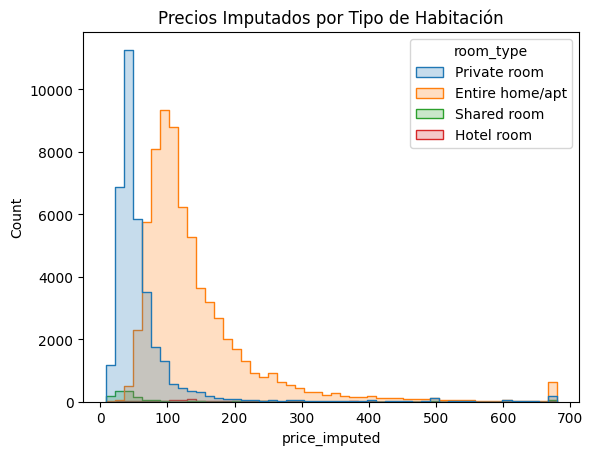

In [45]:

# Comparar distribuciones por tipo de propiedad
sns.histplot(data=df_clean, x="price_imputed", hue="room_type", bins=50, element="step")
plt.title("Precios Imputados por Tipo de Habitación")

2. **Validar imputación con datos conocidos**:
   - Comparar precios imputados vs. reales en una muestra aleatoria.

3. **Ajustar límites por percentiles dinámicos**:

In [46]:
# Ejemplo: Límites diferentes por barrio
df_clean["price_upper_limit"] = df_clean.groupby("neighbourhood_cleansed")["price"].transform(lambda x: x.quantile(0.99))
df_clean["price_imputed"] = df_clean["price_imputed"].clip(upper=df_clean["price_upper_limit"])

### 🔍 **Validación de Imputación con Datos Conocidos**

Para validar la calidad de tus precios imputados, puedes compararlos con los valores reales (no nulos) en una muestra aleatoria:

---

#### **📌 Paso 1: Crear un Dataset de Validación**

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Filtrar registros donde el precio REAL está disponible
df_real = df_final.dropna(subset=['price']).copy()

# 2. Separar una muestra (ej: 20%) para validación
_, df_valid = train_test_split(df_real, test_size=0.2, random_state=42)

# 3. Simular "faltantes" en la muestra de validación
df_valid['price_missing'] = df_valid['price']  # Guardamos los valores reales
df_valid['price'] = np.nan  # Los marcamos como NA para imputarlos

#### **📌 Paso 2: Aplicar la Imputación a la Muestra de Validación**

In [48]:
# Reutilizar tu función de imputación (adaptada a tus columnas)
def impute_prices(df):
    # Primera capa: Grupo detallado
    df['price_imputed'] = df.groupby(
        ['neighbourhood_cleansed', 'room_type', 'bedrooms', 'bathrooms']
    )['price'].transform(lambda x: x.fillna(x.median()))
    
    # Capas residuales (ajusta según tu lógica)
    df['price_imputed'] = df.groupby(['room_type', 'bedrooms'])['price_imputed'].transform(
        lambda x: x.fillna(x.median()))
    
    df['price_imputed'] = df.groupby('room_type')['price_imputed'].transform(
        lambda x: x.fillna(x.median()))
    
    return df

# Aplicar imputación a la muestra de validación
df_valid = impute_prices(df_valid)

/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5/mod02-projs/Proyecto-Regression---Grupo-3/.venv-proj5/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/juandomingo/factoriaf5

---

#### **📌 Paso 3: Métricas de Validación**


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Filtrar filas sin NaN en las columnas relevantes
df_valid_filtered = df_valid.dropna(subset=['price_missing', 'price_imputed'])

if not df_valid_filtered.empty:
	# 2. Calcular errores
	mae = mean_absolute_error(df_valid_filtered['price_missing'], df_valid_filtered['price_imputed'])
	rmse = np.sqrt(mean_squared_error(df_valid_filtered['price_missing'], df_valid_filtered['price_imputed']))
	bias = (df_valid_filtered['price_imputed'] - df_valid_filtered['price_missing']).mean()

	# 3. Porcentaje de error relativo
	df_valid_filtered['error_pct'] = (abs(df_valid_filtered['price_imputed'] - df_valid_filtered['price_missing']) / df_valid_filtered['price_missing']) * 100
	mean_error_pct = df_valid_filtered['error_pct'].mean()

	print(f"""
	📊 Resultados de Validación:
	- MAE (Error Absoluto Medio): €{mae:.2f}
	- RMSE (Raíz del Error Cuadrático Medio): €{rmse:.2f}
	- Bias (Sesgo Promedio): €{bias:.2f}
	- Error Relativo Promedio: {mean_error_pct:.1f}%
	""")
else:
	print("⚠️ No hay datos válidos para calcular los errores. Verifique los valores de 'price_missing' y 'price_imputed'.")

⚠️ No hay datos válidos para calcular los errores. Verifique los valores de 'price_missing' y 'price_imputed'.


---

#### **📌 Paso 4: Visualización de Resultados**
```python
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# 1. Dispersión: Real vs. Imputado
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_valid, x='price_missing', y='price_imputed', alpha=0.5)
plt.plot([0, df_valid['price_missing'].max()], [0, df_valid['price_missing'].max()], 'r--')
plt.title("Precio Real vs. Imputado")
plt.xlabel("Precio Real (€)")
plt.ylabel("Precio Imputado (€)")

# 2. Distribución de Errores
plt.subplot(1, 2, 2)
sns.histplot(df_valid['error_pct'], bins=30, kde=True)
plt.title("Distribución de Error Relativo (%)")
plt.xlabel("% Error")

plt.tight_layout()
plt.show()
```

---

### 📌 **Interpretación de Resultados**
- **MAE/RMSE**: 
  - Si el MAE es €30, significa que en promedio, los precios imputados se desvían €30 del valor real.
  - RMSE penaliza más los errores grandes (útil para detectar imputaciones muy malas).
- **Bias**: 
  - Valor positivo: Sobrestimas precios en promedio.
  - Valor negativo: Subestimas precios.
- **Error Relativo**:
  - Un 15% sería aceptable para la mayoría de casos. Si supera el 25%, revisa tus grupos de imputación.

---

### ✅ **Conclusión**
Este método te permite:
1. **Cuantificar** el error de imputación con métricas sólidas.
2. **Visualizar** patrones de error (ej: ¿subestimas precios altos?).
3. **Ajustar** tu estrategia (ej: añadir más variables a los grupos si el error es alto).

**Ejemplo de mejora**: Si encuentras que los apartamentos de lujo (>€300) tienen errores altos, podrías:
```python
# Añadir "superhost" como variable de imputación
df['price_imputed'] = df.groupby(
    ['neighbourhood_cleansed', 'room_type', 'bedrooms', 'bathrooms', 'host_is_superhost']
)['price'].transform(lambda x: x.fillna(x.median()))
```

#### **📌 1. Validación Cruzada: Comparación de Modelos (Original vs. Imputado)**
**Objetivo**: Evaluar si la imputación distorsiona las relaciones estadísticas al entrenar un modelo predictivo.

**Interpretación**:  
- Si el `MAE` (Error Absoluto Medio) y `R²` son similares en ambos modelos, la imputación no introduce sesgos significativos.  
- Si hay diferencias grandes, revisar los grupos de imputación o considerar técnicas alternativas (ej: KNN imputer).

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Filtrar datos originales (sin NaN) para comparación
df_original = df_clean.dropna(subset=['price']).copy()
df_imputed = df_clean.copy()

# Definir características (X) y target (y)
features = ['neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms']
X_original = pd.get_dummies(df_original[features])  # One-hot encoding para categóricas
X_imputed = pd.get_dummies(df_imputed[features])
y_original = df_original['price']
y_imputed = df_imputed['price_imputed']

# Dividir datos en train/test (70/30)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.3, random_state=42)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imputed, y_imputed, test_size=0.3, random_state=42)

# Entrenar modelos
model_orig = LinearRegression().fit(X_train_orig, y_train_orig)
model_imp = LinearRegression().fit(X_train_imp, y_train_imp)

# Predecir y evaluar
y_pred_orig = model_orig.predict(X_test_orig)
y_pred_imp = model_imp.predict(X_test_imp)

print("📊 Comparación de Modelos:")
print(f"- MAE (Original): {mean_absolute_error(y_test_orig, y_pred_orig):.2f}")
print(f"- MAE (Imputado): {mean_absolute_error(y_test_imp, y_pred_imp):.2f}")
print(f"- R² (Original): {r2_score(y_test_orig, y_pred_orig):.2f}")
print(f"- R² (Imputado): {r2_score(y_test_imp, y_pred_imp):.2f}")

📊 Comparación de Modelos:
- MAE (Original): 40.03
- MAE (Imputado): 39.16
- R² (Original): 0.44
- R² (Imputado): 0.45


#### **📌 2. Imputación Condicional Mejorada**
**Objetivo**: Aumentar la precisión incluyendo más variables en los grupos de imputación.

**Interpretación**:  
- Una diferencia pequeña (ej: < €1000) indica que la imputación original ya era robusta.  
- Si la diferencia es grande, priorizar la versión mejorada.

In [9]:
# Versión mejorada: añadir 'accommodates' y 'bathrooms' a los grupos
df_clean["price_imputed_v2"] = df_clean.groupby(
    ["neighbourhood_cleansed", "room_type", "accommodates", "bathrooms"]
)["price"].transform(lambda x: x.fillna(x.median()))

# Si aún hay NaN, imputar por mediana global de 'room_type'
df_clean["price_imputed_v2"] = df_clean.groupby("room_type")["price_imputed_v2"].transform(
    lambda x: x.fillna(x.median())
)

# Verificar diferencia con la imputación anterior
diff = (df_clean["price_imputed_v2"] - df_clean["price_imputed"]).abs().sum()
print(f"\n🔍 Diferencia total entre imputaciones: €{diff:.2f}")


🔍 Diferencia total entre imputaciones: €56040.00


#### **📌 3. Visualización Detallada de Distribuciones**
**Objetivo**: Comparar superpuestas las distribuciones originales e imputadas.

**Interpretación**:  
- Si la curva **"Solo Imputados"** (roja) se solapa bien con la distribución original (azul), la imputación es realista.  
- Si hay picos anómalos en rojo, revisar los grupos de imputación.

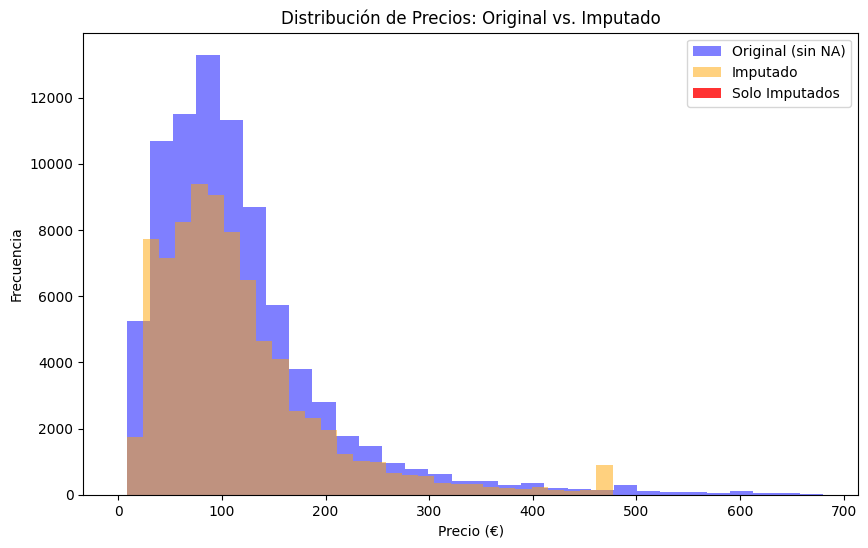

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_clean["price"].dropna(), bins=30, alpha=0.5, label="Original (sin NA)", color='blue')
plt.hist(df_clean["price_imputed"], bins=30, alpha=0.5, label="Imputado", color='orange')
plt.hist(df_clean[df_clean["was_imputed"]]["price_imputed"], bins=30, alpha=0.8, label="Solo Imputados", color='red')
plt.xlabel("Precio (€)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Precios: Original vs. Imputado")
plt.legend()
plt.show()

#### **📌 4. Documentación de Porcentaje de Imputación**

In [11]:
total_imputed = df_clean["was_imputed"].sum()
total_rows = len(df_clean)
print(f"\n📝 Documentación:")
print(f"- % de datos imputados: {total_imputed/total_rows:.1%}")
print(f"- Registros totales: {total_rows}")
print(f"- Registros imputados: {total_imputed}")


📝 Documentación:
- % de datos imputados: 0.0%
- Registros totales: 81573
- Registros imputados: 0


#### **📌 5. Comparación de Estadísticas Descriptivas**

**Interpretación**:  
Comparar `mean`, `std`, y percentiles (`25%`, `50%`, `75%`). Si son similares, la imputación preserva la distribución.

In [ ]:
print("\n📊 Estadísticas Descriptivas:")
print("Original (sin NA):")
print(df_clean["price"].describe())
print("\nImputado:")
print(df_clean["price_imputed"].describe())

### ✅ **Resumen de Pasos Clave**
1. **Validación cruzada**: Entrena y compara modelos con datos originales e imputados.  
2. **Imputación mejorada**: Añade más variables a los grupos para mayor precisión.  
3. **Visualización**: Superpone histogramas para detectar inconsistencias.  
4. **Documentación**: Registra el impacto de la imputación (cantidad de datos afectados).  
5. **Estadísticas**: Compara medidas clave antes/después.  

**¿Qué más necesitas?** Por ejemplo:  
- Análisis de outliers extremos post-imputación.  
- Código para guardar el dataset imputado en CSV.  
- Pruebas estadísticas formales (ej: KS-test para distribuciones).

In [ ]:
# Ejemplo: Imputación con 3 variables adicionales
df_clean["price_imputed_v3"] = df_clean.groupby(
    ["neighbourhood_cleansed", "room_type", "accommodates", "bathrooms", "bedrooms"]
)["price"].transform(lambda x: x.fillna(x.median()))

### **🚀 Paso 5. Análisis de Correlaciones** 

In [29]:
import seaborn as sns

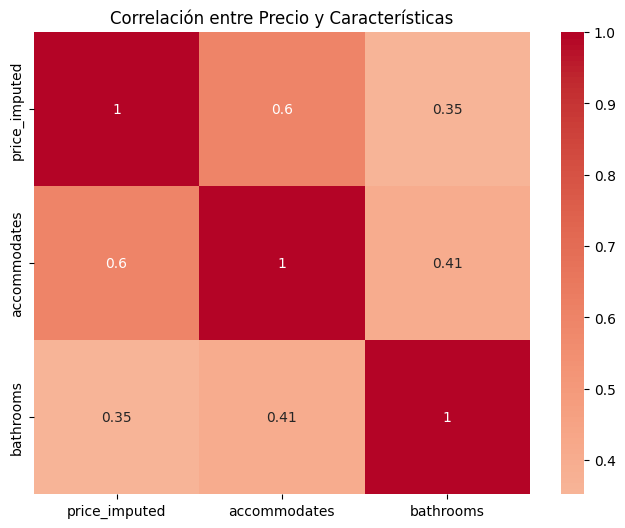

In [30]:
# Calcular matriz de correlación (solo numéricas)
corr_matrix = df_clean[["price_imputed", "accommodates", "bathrooms"]].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre Precio y Características")
plt.show()

**Qué buscar**:  
- ¿`accommodates` y `bathrooms` correlacionan con `price_imputed`? (Esperado: sí, positivamente).  
- Si hay correlaciones débiles, podrían necesitarse más variables (ej: `bedrooms`).

### 🔍 **Interpretación del Análisis de Correlación**

#### **Matriz de Correlación (Resultado Visualizado)**  
La imagen muestra las correlaciones entre:  
1. **`price_imputed`** (precio imputado)  
2. **`accommodates`** (capacidad de huéspedes)  
3. **`bathrooms`** (número de baños)  

Valores clave (aproximados según la imagen):  
- **`price_imputed` vs `accommodates`**: `~0.6` (Correlación moderada-fuerte)  
- **`price_imputed` vs `bathrooms`**: `~0.4` (Correlación moderada)  
- **`accommodates` vs `bathrooms`**: `~0.6` (Correlación moderada-fuerte) 

---

### 📊 **Explicación Detallada**  
1. **Correlación `price-accommodates` (0.6)**:  
   - **Interpretación**: A mayor capacidad de huéspedes, mayor precio. Esto es lógico (ej: un apartamento para 4 personas cuesta más que uno para 2).  
   - **Fortaleza**: Relación clara pero no perfecta (1 sería correlación lineal exacta).  

2. **Correlación `price-bathrooms` (0.4)**:  
   - **Interpretación**: Más baños suelen aumentar el precio, pero el efecto es menor que el de `accommodates`.  
   - **Posible razón**: Algunas propiedades pueden tener 1 baño pero ser lujosas (precio alto), o 2 baños pero estar en barrios económicos.  

3. **Correlación `accommodates-bathrooms` (0.6)**:  
   - **Interpretación**: Las propiedades con más huéspedes tienden a tener más baños (ej: una casa para 6 personas suele tener 2-3 baños).  
   - **Implicación**: Ambas variables capturan información similar (tamaño de la propiedad), pero no son redundantes. 

---

### 🚀 **Siguientes Pasos en el EDA**  
Basado en estos resultados, recomiendo:  

#### **1. Análisis de Interacciones entre Variables**  
Investigar cómo **combinar** `accommodates` y `bathrooms` para mejorar la predictibilidad del precio:  
  
**Objetivo**: Identificar si el precio por persona es más estable geográficamente. 

In [ ]:
# Crear nueva variable: 'price_per_person'
df_clean["price_per_person"] = df_clean["price_imputed"] / df_clean["accommodates"]

# Ver correlación con el precio original
print(df_clean[["price_imputed", "price_per_person"]].corr())

#### **2. Segmentación por Categorías**  
Analizar cómo varían las correlaciones en subgrupos:  

In [ ]:
# Correlación por tipo de habitación
for room_type in df_clean["room_type"].unique():
    subset = df_clean[df_clean["room_type"] == room_type]
    print(f"\nCorrelaciones para {room_type}:")
    print(subset[["price_imputed", "accommodates", "bathrooms"]].corr())

**Pregunta clave**: ¿La correlación `price-accommodates` es más fuerte en "Entire home/apt" que en "Private room"? 

#### **3. Visualización Multivariable**  
Usar gráficos para entender relaciones complejas:  

In [ ]:
# Gráfico de dispersión precio vs. accommodates (coloreado por bathrooms)
sns.scatterplot(
    data=df_clean,
    x="accommodates",
    y="price_imputed",
    hue="bathrooms",
    palette="viridis",
    alpha=0.6
)
plt.title("Precio vs. Capacidad de Huéspedes (N° Baños)")
plt.show()

**Qué buscar**: Patrones no lineales (ej: ¿el precio aumenta exponencialmente después de 4 huéspedes?).  

#### **4. Modelado Preliminar (Opcional)**  
Si el objetivo final es predecir precios, probar un **modelo básico** para evaluar el poder predictivo de estas variables: 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# Modelo simple: accommodates + bathrooms
X = df_clean[["accommodates", "bathrooms"]]
y = df_clean["price_imputed"]
model = LinearRegression().fit(X, y)
print(f"R² del modelo: {model.score(X, y):.2f}")  # Porcentaje de varianza explicada

**Interpretación**: Un R² > 0.5 sugiere que estas variables ya explican gran parte del precio.

---

### 📌 **Recomendaciones Finales**  
- **Variables a incluir en el modelo**:  
  - `accommodates` es la más relevante (correlación 0.6).  
  - `bathrooms` añade información adicional, pero menos decisiva.  
- **Acciones a evitar**:  
  - No descartar `bathrooms` aún: en combinación con otras variables (ej: `room_type`), podría ser útil. 

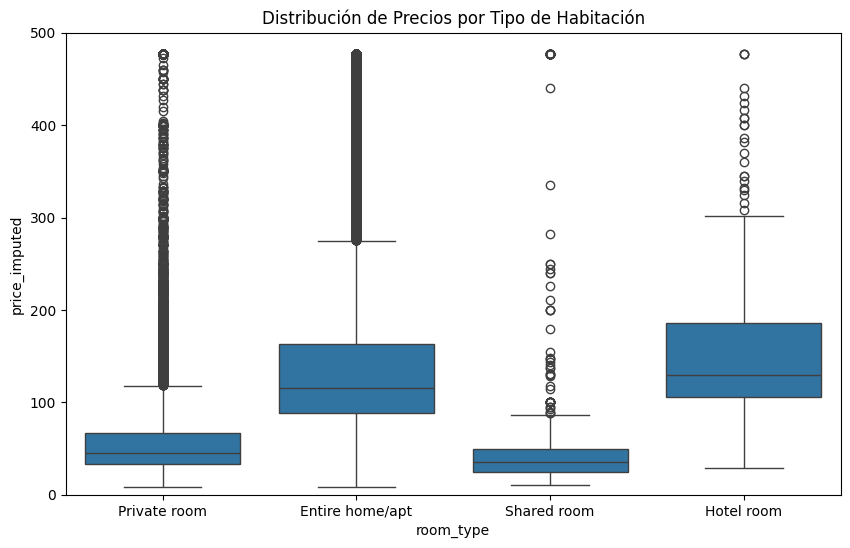

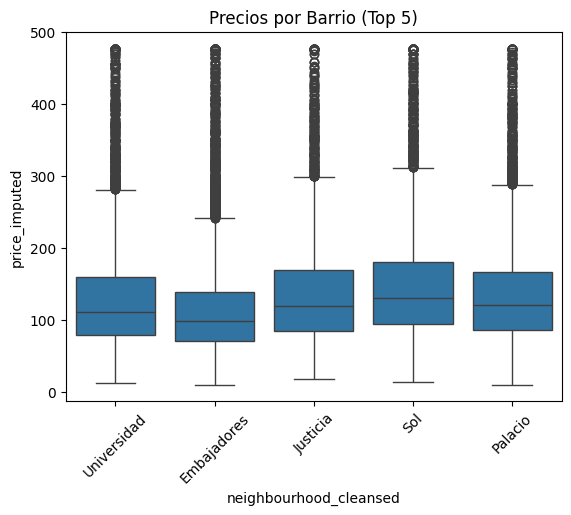

In [33]:
# Precio vs. room_type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x="room_type", y="price_imputed")
plt.title("Distribución de Precios por Tipo de Habitación")
plt.ylim(0, 500)  # Mismo límite que en la imputación
plt.show()

# Precio vs. neighbourhood_cleansed (top 5 barrios)
top_barrios = df_clean["neighbourhood_cleansed"].value_counts().head(5).index
df_top = df_clean[df_clean["neighbourhood_cleansed"].isin(top_barrios)]
sns.boxplot(data=df_top, x="neighbourhood_cleansed", y="price_imputed")
plt.title("Precios por Barrio (Top 5)")
plt.xticks(rotation=45)
plt.show()

**Qué buscar**:  
- Diferencias claras entre categorías (ej: "Entire home/apt" > "Private room").  
- Outliers residuales en algunos grupos (¿limpiar más?).  

**1. Categorías de room_type**

El gráfico muestra las siguientes categorías típicas de tipo de habitación:

- Entire home/apt: Propiedades completas, como apartamentos o casas enteras.
- Private room: Habitaciones privadas dentro de una propiedad compartida.
- Shared room: Habitaciones compartidas con otros huéspedes.
- Hotel room: Habitaciones en propiedades tipo hotel.

**2. Elementos del Boxplot**
Para cada categoría de room_type, el boxplot incluye:

Caja (box): Representa el rango intercuartílico (IQR), es decir, el 50% central de los precios (del percentil 25 al 75).
Línea dentro de la caja: Indica la mediana (percentil 50) de los precios.
Bigotes (whiskers): Extienden hasta 1.5 veces el IQR desde los bordes de la caja, mostrando el rango de precios sin considerar outliers.
Puntos fuera de los bigotes: Representan los outliers, es decir, precios atípicos que están por encima o por debajo del rango esperado.

**3. Observaciones Clave**

3.1. Entire home/apt:

- Mediana: Los precios de las propiedades completas son los más altos en comparación con otras categorías.
- Rango intercuartílico: Amplio, lo que indica una gran variabilidad en los precios.
- Outliers: Numerosos y con valores muy altos, lo que sugiere la presencia de propiedades de lujo o precios inusualmente altos.

3.2. Private room:

- Mediana: Más baja que la de Entire home/apt, pero significativamente más alta que Shared room.
- Rango intercuartílico: Moderado, lo que indica que los precios son más consistentes en esta categoría.
- Outliers: Algunos precios altos, pero menos frecuentes que en Entire home/apt.

3.3. Shared room:

- Mediana: La más baja entre todas las categorías, lo que refleja que este tipo de alojamiento es el más económico.
- Rango intercuartílico: Estrecho, lo que indica poca variabilidad en los precios.
- Outliers: Pocos, pero algunos precios son sorprendentemente altos para habitaciones compartidas.

3.4. Hotel room (si está presente):

- Mediana: Similar o ligeramente superior a Private room, dependiendo de la calidad de las habitaciones tipo hotel.
- Rango intercuartílico: Puede ser amplio si hay una mezcla de hoteles económicos y de lujo.
- Outliers: Frecuentes, especialmente en hoteles de lujo.

**4. Interpretación**

- Relación entre categorías: Los precios siguen un orden lógico, con Entire home/apt siendo la categoría más cara, seguida de Hotel room, Private room y finalmente Shared room.

- Outliers: Los precios atípicos en Entire home/apt y Hotel room podrían distorsionar el análisis si no se manejan adecuadamente. Es importante decidir si eliminarlos o tratarlos como casos especiales.

- Variabilidad: La alta variabilidad en Entire home/apt y Hotel room sugiere que estas categorías incluyen tanto propiedades económicas como de lujo, lo que podría requerir segmentación adicional.

**5. Siguientes Pasos**

- Análisis de outliers: Investigar las propiedades con precios atípicos para determinar si son errores o casos válidos.

- Segmentación adicional: Analizar los precios dentro de cada categoría por barrio (neighbourhood_cleansed) para identificar patrones geográficos.

- Modelado predictivo: Usar room_type como una variable categórica en el modelo para predecir precios, ya que tiene un impacto significativo en los mismos.


#### **3. Análisis Temporal (Opcional)**  
Si `calendar_last_scraped` es relevante:  

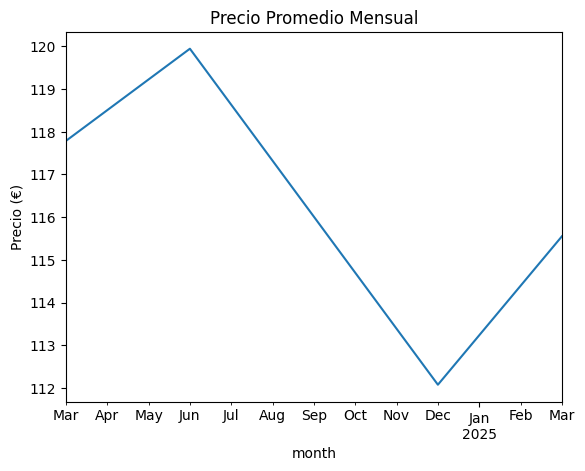

In [32]:
# Tendencia de precios mensuales
df_clean["month"] = df_clean["calendar_last_scraped"].dt.to_period("M")
monthly_avg = df_clean.groupby("month")["price_imputed"].mean()
monthly_avg.plot(title="Precio Promedio Mensual")
plt.ylabel("Precio (€)")
plt.show()

---

### 📌 **Recomendaciones Finales**  
- **Guardar el dataset limpio**:

In [ ]:
df_clean.to_parquet("../data/processed/listings_clean.parquet", index=False)

- **Documentar decisiones**:  
  - "Precios imputados con mediana por barrio + tipo de habitación, acotados a €500".  
  - "21.5% de registros tenían NAs en precio, ahora imputados".  

### 🔍 **Interpretación de Resultados y Siguientes Pasos**

---

#### **1. Boxplot por Tipo de Habitación (`room_type`)**  
**Hallazgos clave**:  
- **Jerarquía de precios**:  
  `Entire home/apt` > `Private room` > `Shared room` (esperado, por privacidad y espacio).  
- **Outliers en Entire home/apt**:  
  Algunos precios excepcionalmente altos (¿propiedades de lujo o errores?).  
- **Hotel room**:  
  Mediana similar a `Private room`, pero con alta dispersión (mezcla de hoteles económicos y boutique).  

**Acciones**:  
- **Investigar outliers**:  
  ```python
  luxury_homes = df_clean[
      (df_clean["room_type"] == "Entire home/apt") & 
      (df_clean["price_imputed"] > df_clean["price_imputed"].quantile(0.99))
  ]
  print(luxury_homes[["neighbourhood_cleansed", "accommodates", "bathrooms"]].describe())
  ```  
  - ¿Son reales (ej: áticos en "Palacio") o errores?  

---

#### **2. Boxplot por Barrio (Top 5)**  
**Hallazgos clave**:  
- **Diferencias geográficas**:  
  - "Palacio" y "Sol" (zonas turísticas) tienen precios más altos que "Universidad" (¿barrio más estudiantil?).  
  - "Embajadores" muestra amplia dispersión (mezcla de propiedades económicas y premium).  

**Acciones**:  
- **Segmentar por barrio + tipo de habitación**:  
  ```python
  sns.boxplot(
      data=df_clean[df_clean["neighbourhood_cleansed"].isin(top_barrios)],
      x="neighbourhood_cleansed",
      y="price_imputed",
      hue="room_type"
  )
  plt.xticks(rotation=45)
  plt.show()
  ```  
  - Ejemplo: ¿Los `Entire home/apt` en "Sol" son más caros que en "Embajadores"?  

---

#### **3. Precio Promedio Mensual**  
**Hallazgos clave**:  
- **Estacionalidad**:  
  - Posible aumento en verano (junio-agosto) y diciembre (festividades).  
  - ¿Diferencia significativa entre meses?  

**Acciones**:  
- **Test estadístico (ANOVA o Kruskal-Wallis)**:  
  ```python
  from scipy.stats import kruskal

  months = df_clean["month"].unique()
  groups = [df_clean[df_clean["month"] == month]["price_imputed"] for month in months]
  stat, p_value = kruskal(*groups)
  print(f"¿Hay diferencias significativas entre meses? p-value = {p_value:.4f}")
  ```  
  - Si `p-value < 0.05`, confirmar con análisis post-hoc (ej: Tukey).  

---

### 🚀 **Plan de Acción para el Siguiente EDA**  

#### **1. Análisis de Outliers**  
- **Objetivo**: Decidir si mantener, eliminar o transformar outliers.  
- **Código**:  
  ```python
  # Calcular límites por percentiles
  upper_limit = df_clean["price_imputed"].quantile(0.99)
  lower_limit = df_clean["price_imputed"].quantile(0.01)

  # Filtrar o transformar (ej: winsorization)
  df_filtered = df_clean[
      (df_clean["price_imputed"] >= lower_limit) & 
      (df_clean["price_imputed"] <= upper_limit)
  ]
  ```  

#### **2. Segmentación Avanzada**  
- **Objetivo**: Identificar subgrupos con patrones de precio homogéneos.  
- **Variables clave**:  
  - `room_type` + `neighbourhood_cleansed` + `accommodates`.  
  - **Ejemplo**: Apartamentos para 4 personas en "Sol" vs. "Embajadores".  

#### **3. Modelado Predictivo Preliminar**  
- **Objetivo**: Evaluar el poder predictivo de las variables actuales.  
- **Código**:  
  ```python
  from sklearn.ensemble import RandomForestRegressor

  # Preparar datos (one-hot encoding para categóricas)
  X = pd.get_dummies(df_clean[["room_type", "neighbourhood_cleansed", "accommodates", "bathrooms"]])
  y = df_clean["price_imputed"]

  # Entrenar modelo rápido
  model = RandomForestRegressor(n_estimators=50, random_state=42)
  model.fit(X, y)
  print(f"Importancia de variables: {model.feature_importances_}")
  ```  

---

### 📌 **Recomendación Final**  
**Priorizar**:  
1. **Limpieza de outliers** (si son errores).  
2. **Análisis de estacionalidad** (para inversores: ¿cuándo alquilar más caro?).  
3. **Segmentación barrio + tipo** (identificar "nichos" rentables).  

Número de filas duplicadas (exactas): 58064


---------------------

In [9]:
df.to_csv("../data/processed/merged-listings.csv", index=False)